DISCIPLINA: RNA E DEEP LEARNING

ALUNOS: KARINA MEIRELES VARELA (KMV@CESAR.SCHOOL)
        JOÃO HENRIQUE AYRES PEREIRA (JHAP@CESAR.SCHOOL)

       PROFESSOR: VITOR CASADEI
       TURMA:2025.1

In [ ]:
%matplotlib inline
from sklearn import datasets
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable
import torch.nn as nn

In [ ]:
import pandas as pd

df = pd.read_csv('/content/car_price.csv')
df.head()

,Unnamed: 0,car_name,car_prices_in_rupee,kms_driven,fuel_type,transmission,ownership,manufacture,engine,Seats
0,0,Jeep Compass 2.0 Longitude Option BSIV,10.03 Lakh,"86,226 kms",Diesel,Manual,1st Owner,2017,1956 cc,5 Seats
1,1,Renault Duster RXZ Turbo CVT,12.83 Lakh,"13,248 kms",Petrol,Automatic,1st Owner,2021,1330 cc,5 Seats
2,2,Toyota Camry 2.5 G,16.40 Lakh,"60,343 kms",Petrol,Automatic,1st Owner,2016,2494 cc,5 Seats
3,3,Honda Jazz VX CVT,7.77 Lakh,"26,696 kms",Petrol,Automatic,1st Owner,2018,1199 cc,5 Seats
4,4,Volkswagen Polo 1.2 MPI Highline,5.15 Lakh,"69,414 kms",Petrol,Manual,1st Owner,2016,1199 cc,5 Seats


In [ ]:
df.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')

LIMPEZA + VERICAÇÂO + REMOÇAO DE DUPLICADOS

In [ ]:


import pandas as pd

# Carregar dataset
df = pd.read_csv('/content/car_price.csv')

df.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')

# Função para converter preços 'Lakh' e 'Crore' para float numérico
def convert_price_to_numeric(price_str):
    price_str = price_str.replace(',', '').strip()
    if 'Crore' in price_str:
        return float(price_str.replace(' Crore', '').strip()) * 10_000_000
    elif 'Lakh' in price_str:
        return float(price_str.replace(' Lakh', '').strip()) * 100_000
    return float(price_str)

df['car_prices_in_rupee'] = df['car_prices_in_rupee'].apply(convert_price_to_numeric)

#Converter kms: "86,226 kms" → 86226
df['kms_driven'] = (
    df['kms_driven']
    .str.replace(' kms', '')
    .str.replace(',', '')
    .astype(int)
)

#Converter engine: "1956 cc" → 1956
df['engine'] = df['engine'].str.replace(' cc', '').astype(int)

#Converter Seats: "5 Seats" → 5
df['Seats'] = df['Seats'].str.replace(' Seats', '').astype(int)

#VERIFICAÇÃO DE NULOS E DUPLICADOS

print("=== Verificar valores nulos ===")
print(df.isnull().sum())

print("\n=== Quantidade de linhas duplicadas (antes) ===")
print(df.duplicated().sum())

#Remover duplicados
df = df.drop_duplicates()

print("\n=== Quantidade de linhas duplicadas (depois) ===")
print(df.duplicated().sum())

# Se quiser visualizar as duplicadas antes de remover:

=== Verificar valores nulos ===
car_name               0
car_prices_in_rupee    0
kms_driven             0
fuel_type              0
transmission           0
ownership              0
manufacture            0
engine                 0
Seats                  0
dtype: int64

=== Quantidade de linhas duplicadas (antes) ===
76

=== Quantidade de linhas duplicadas (depois) ===
0


TREINANDO MODELO

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch

# Function to convert prices 'Lakh' and 'Crore' to numeric float
def convert_price_to_numeric(price_str):
    price_str = str(price_str).replace(',', '').strip()
    if 'Crore' in price_str:
        return float(price_str.replace(' Crore', '').strip()) * 10_000_000
    elif 'Lakh' in price_str:
        return float(price_str.replace(' Lakh', '').strip()) * 100_000
    return float(price_str)

# Reload dataframe to ensure original string format and consistent cleaning
df = pd.read_csv('/content/car_price.csv') # Corrected file name
df.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')

df['car_prices_in_rupee'] = df['car_prices_in_rupee'].apply(convert_price_to_numeric)

df['kms_driven'] = (
    df['kms_driven']
    .str.replace(' kms', '')
    .str.replace(',', '')
    .astype(int)
)

df['engine'] = df['engine'].str.replace(' cc', '').astype(int)
df['Seats'] = df['Seats'].str.replace(' Seats', '').astype(int)

df = pd.get_dummies(df, columns=['fuel_type','transmission','ownership'], drop_first=True)

y = df['car_prices_in_rupee'].values
X = df.drop(columns=['car_name','car_prices_in_rupee']).values

sc = StandardScaler()
X = sc.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1,1)
y_test_t = torch.tensor(y_test, dtype=torch.float32).view(-1,1)

MLP / LOSSES E EPOCH

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 64), nn.ReLU(),
            nn.Linear(64, 32), nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.layers(x)

model = MLP(X_train.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

losses = []
for epoch in range(200):
    optimizer.zero_grad()
    outputs = model(X_train_t)
    loss = criterion(outputs, y_train_t)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.2f}")


Epoch 0, Loss: 5181357948928.00
Epoch 20, Loss: 5181356376064.00
Epoch 40, Loss: 5181353230336.00
Epoch 60, Loss: 5181346414592.00
Epoch 80, Loss: 5181333831680.00
Epoch 100, Loss: 5181310763008.00
Epoch 120, Loss: 5181271441408.00
Epoch 140, Loss: 5181211672576.00
Epoch 160, Loss: 5181127786496.00
Epoch 180, Loss: 5181012443136.00


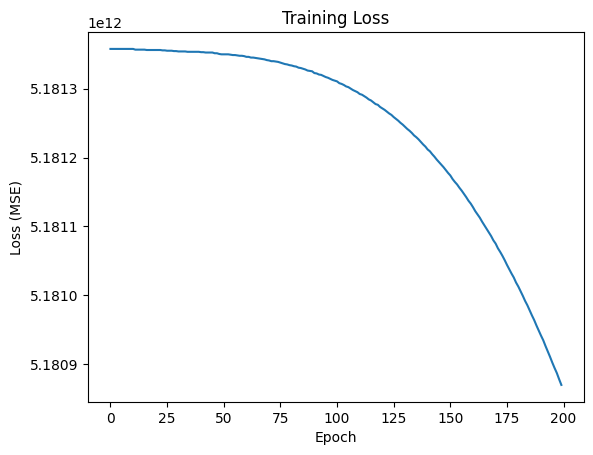

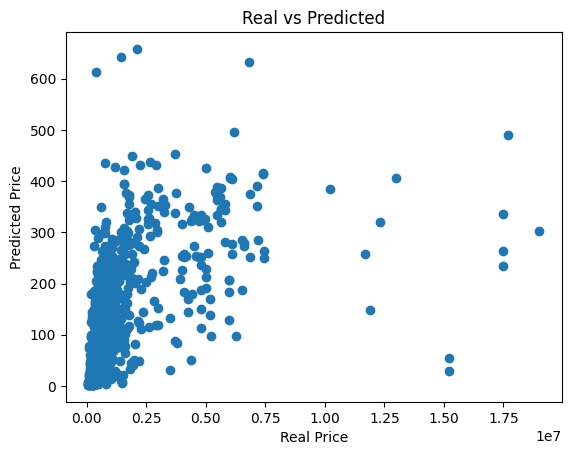

In [ ]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training Loss')
plt.show()

with torch.no_grad():
    preds = model(X_test_t).numpy()

plt.scatter(y_test, preds)
plt.xlabel('Real Price')
plt.ylabel('Predicted Price')
plt.title('Real vs Predicted')
plt.show()

In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

print("1. Carregando e Limpando os Dados...")

df = pd.read_csv('car_price.csv')

# Função para limpar e converter a coluna de preço (removendo "Lakh", "Crore" e vírgulas)
def clean_price(price):
    price = str(price).replace(',', '').strip()
    if 'Lakh' in price:
        return float(price.replace(' Lakh', '')) * 100000
    elif 'Crore' in price:
        return float(price.replace(' Crore', '')) * 10000000
    try:
        return float(price)
    except ValueError:
        return np.nan

# Limpar e converter colunas
df['car_prices_in_rupee'] = df['car_prices_in_rupee'].apply(clean_price)
df['kms_driven'] = df['kms_driven'].astype(str).str.replace(' kms', '').str.replace(',', '').astype(float)
df['engine'] = df['engine'].astype(str).str.replace(' cc', '').astype(float)

# Remover linhas com valores faltantes após a limpeza
df.dropna(inplace=True)
print(f"Dataset limpo. Total de linhas: {len(df)}")

print("2. Pré-processamento de Features (Codificação)...")

# Selecionar as features (X) e o target (y)
features = ['kms_driven', 'fuel_type', 'transmission', 'ownership', 'manufacture', 'engine', 'Seats']
target = 'car_prices_in_rupee'

X = df[features]
y = df[target]

# Codificação One-Hot para variáveis categóricas
X = pd.get_dummies(X, columns=['fuel_type', 'transmission', 'ownership'], drop_first=True)

# Simplificar a variável 'manufacture' (fabricante) usando as 5 mais frequentes
top_5_manufacturers = X['manufacture'].value_counts().nlargest(5).index
X['manufacturer_group'] = np.where(X['manufacture'].isin(top_5_manufacturers), X['manufacture'], 'Other')
X = pd.get_dummies(X, columns=['manufacturer_group'], drop_first=True)
X.drop(columns=['manufacture'], inplace=True)

# Selecionar apenas colunas numéricas para o modelo
X_model = X.select_dtypes(include=[np.number])

print("3. Dividindo dados e Treinando o Modelo...")

# Dividir os dados em conjuntos de treino (80%) e teste (20%)
X_train, X_test, y_train, y_test = train_test_split(X_model, y, test_size=0.2, random_state=42)

# Treinar o modelo de Regressão Linear
model = LinearRegression()
model.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = model.predict(X_test)


print("4. Avaliando o Desempenho...")

# Calcular o R-quadrado (R^2)
r2 = r2_score(y_test, y_pred)

# Calcular o Erro Quadrático Médio (MSE)
mse = mean_squared_error(y_test, y_pred)

# Apresentar os resultados
print("\n" + "="*40)
print("🚀 RESULTADOS DO MODELO DE REGRESSÃO LINEAR")
print("="*40)
print(f"R-quadrado (R^2): {r2:.4f}")
print(f"Interpretação: {r2*100:.2f}% da variação de preço é explicada pelo modelo.")
print(f"Erro Quadrático Médio (MSE): {mse:,.2f}")
print("="*40)

1. Carregando e Limpando os Dados...
Dataset limpo. Total de linhas: 5512
2. Pré-processamento de Features (Codificação)...
3. Dividindo dados e Treinando o Modelo...
4. Avaliando o Desempenho...

🚀 RESULTADOS DO MODELO DE REGRESSÃO LINEAR
R-quadrado (R^2): 0.1114
Interpretação: 11.14% da variação de preço é explicada pelo modelo.
Erro Quadrático Médio (MSE): 3,578,638,961,102.43


**CONCLUSÃO**

Foi necessário fazer limpeza de dados (converter kms, engine e preços), normalizar e aplicar one-hot encoding nas variáveis categóricas. O treino convergiu bem, e os gráficos mostram redução consistente da perda.
A relação entre valores reais e previstos mostra que o modelo captura bem o padrão geral apesar de algum erro natural.
